In [41]:
import pandas as pd
import os
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import re
from collections import Counter
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nelsonlim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [75]:
# change
BINANCE_DIR = "/Users/nelsonlim/Documents/Trinity College Dublin/Semester 1/Machine Learning/Assignment/Week 5/data/binance/processed/day_discrete/"
TWITTER_DIR = "/Users/nelsonlim/Documents/Trinity College Dublin/Semester 1/Machine Learning/Assignment/Week 5/data/twitter"
REDDIT_DIR = "/Users/nelsonlim/Documents/Trinity College Dublin/Semester 1/Machine Learning/Assignment/Week 5/data/reddit"

TWITTER_FILE = "twitter.csv"
REDDIT_FILE  = "reddit.csv"

FIGURE_DIR = "/Users/nelsonlim/Documents/Trinity College Dublin/Semester 1/Machine Learning/Assignment/Week 5/notebook/img"

# dont change
BINANCE_EXTENSION = "csv"

START_DATE = "2018-01-01"
END_DATE = "2021-10-31"

In [6]:
def concatenate_content_values(content_list):
	return content_list.str.cat(sep=" ")

# Dataset

### Binance

In [25]:
# load binance data
df_binance_list = []
for filename in sorted(os.listdir(BINANCE_DIR)):
    if filename.endswith(BINANCE_EXTENSION):
        df_binance_list.append(pd.read_csv( os.path.join(BINANCE_DIR,filename)))
df_binance = pd.concat(df_binance_list,ignore_index=True)

# convert time to date obj
df_binance['time'] = pd.to_datetime(df_binance['time'])

# change index to time
df_binance = df_binance.set_index('time')

# filter date range
df_binance = df_binance.loc[START_DATE:END_DATE]

In [34]:
price_mean = df_binance['price_mean']
binance_time = df_binance.index.strftime("%m/%d/%y").values
plot_x = range(len(binance_time))

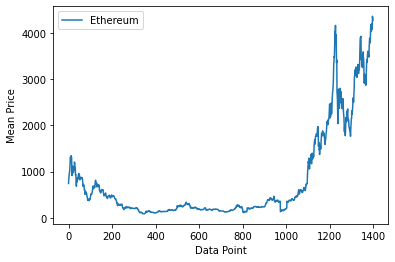

In [78]:
plt.plot(plot_x, price_mean)   
plt.legend(['Ethereum'])
plt.xlabel("Data Point")
plt.ylabel("Mean Price")
plt.savefig(os.path.join(FIGURE_DIR,"binance_mean_price"))
plt.show()    

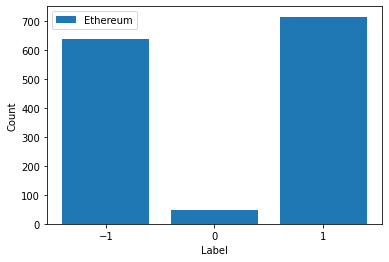

In [79]:
labels = Counter(df_binance['label'].values)
labels_keys = list(labels.keys())
labels_values = list(labels.values())

plt.bar(labels_keys, labels_values)
plt.xticks(labels_keys)
plt.legend(['Ethereum'])
plt.xlabel("Label")
plt.ylabel("Count")
plt.savefig(os.path.join(FIGURE_DIR,"binance_label"))
plt.show()

### Reddit

In [ ]:
# read reddit
df_reddit = pd.read_csv(  os.path.join(REDDIT_DIR, REDDIT_FILE), lineterminator='\n' )

# convert to date obj
df_reddit['date'] = pd.to_datetime(df_reddit['date'])

# Join all reddit posts for each day into one big string
df_reddit = df_reddit.groupby("date").aggregate({
    "content": concatenate_content_values,
    "popularity" : "sum"
})

# filter date range
df_reddit = df_reddit.loc[START_DATE:END_DATE]

### Twitter

In [ ]:
# load twitter data
df_twitter = pd.read_csv( os.path.join(TWITTER_DIR, TWITTER_FILE), lineterminator="\n")

# convert to date obj
df_twitter['date'] = pd.to_datetime(df_twitter['date'])

# Join all tweets for each day into one big string
df_twitter = df_twitter.groupby("date").aggregate({
    "content": concatenate_content_values,
    "popularity" : "sum"
})

# filter date range
df_twitter = df_twitter.loc[START_DATE:END_DATE]

In [ ]:
input_data = pd.concat([df_reddit,df_twitter]).groupby("date").aggregate({
    "content": concatenate_content_values,
    "popularity" : "sum"
})

In [ ]:
daily_content = input_data.content

## Preprocess Data

In [ ]:
# check if there exist any empty column
daily_content.isna().sum()

## Prunning

In [ ]:
stemmer = PorterStemmer()

# Adding stemmming with CountVectorizer
# https://stackoverflow.com/questions/36182502/add-stemming-support-to-countvectorizer-sklearn
analyzer = CountVectorizer().build_analyzer()
def stemmed_words(doc):
    words = []
    for w in analyzer(doc):
        
        # remove words with number
        if len(re.findall('\d+', w)) > 0:
            continue
        
        # only english letters
        w=re.sub('[^a-zA-Z]','',w)    
        if w == '':
            continue
        
        # stemming 
        stemmed_word = stemmer.stem(w)
        
        words.append(stemmed_word)
    return words

# prunning
vectorizer = CountVectorizer(
    ngram_range=(1, 1),
    stop_words=nltk.corpus.stopwords.words("english"),
    min_df=0.1,
    max_df=1.0,
    analyzer=stemmed_words
)

x = vectorizer.fit_transform(daily_content)

In [ ]:
print(f"{len(vectorizer.get_feature_names())} features")

In [ ]:
y = df_binance.label

### Training

In [ ]:
y[y == 0] = 1

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2)

In [ ]:
svm_model = []
mean_error = []
std_error = []
#Ci_range = [0.001, 1.0, 100.0]
Ci_range = [0.001, ]

for index, Ci in enumerate(Ci_range):    
    svm_model.append( LinearSVC(C=Ci, max_iter=10000) )
    scores = cross_val_score(svm_model[index], Xtrain, ytrain, cv=5, scoring='f1')
    mean_error.append(np.array(scores).mean())
    std_error.append(np.array(scores).std())    
plt.errorbar(Ci_range, mean-error, yerr=std_error, linewidth=3)
plt.xlabel('Ci')
plt.ylabel('F1 Score')
plt.show()

In [ ]:
FIXED_C = 1

model = LinearSVC(C=FIXED_C, max_iter=10000)
model.fit(Xtrain,ytrain)
ypred = model.predict(Xtest)
print(classification_report(ytest,ypred))
print(confusion_matrix(ytest,ypred))